In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score
import torch
from torch import nn

df = pd.read_csv("data/synthetic_em_data.csv")
X = df[["Time", "Depth", "Resistivity"]].values
y = df["dBdt"].values.reshape(-1, 1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
class EMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

model = EMModel()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)

for epoch in range(10000):
    model.train()
    y_pred = model(X_train_t)
    loss = loss_fn(y_pred, y_train_t)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0 or epoch == 9999:
        # print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

        y_pred_np = y_pred.detach().numpy()
        y_train_np = y_train

        y_pred_bin = (y_pred_np > 0).astype(int)
        y_train_bin = (y_train_np > 0).astype(int)

        precision = precision_score(y_train_bin, y_pred_bin, zero_division=0)
        print(f"Epoch {epoch}: Loss = {loss.item():.6f} Precision: {precision:.4f}")


Epoch 0: Loss = 1.010030
Epoch 100: Loss = 1.000592
Epoch 200: Loss = 0.999930
Epoch 300: Loss = 0.999054
Epoch 400: Loss = 0.997815
Epoch 500: Loss = 0.996471
Epoch 600: Loss = 0.995290
Epoch 700: Loss = 0.994448
Epoch 800: Loss = 0.993955
Epoch 900: Loss = 0.993704
Epoch 1000: Loss = 0.993534
Epoch 1100: Loss = 0.993472
Epoch 1200: Loss = 0.993345
Epoch 1300: Loss = 0.993264
Epoch 1400: Loss = 0.993197
Epoch 1500: Loss = 0.993177
Epoch 1600: Loss = 0.993093
Epoch 1700: Loss = 0.993049
Epoch 1800: Loss = 0.992949
Epoch 1900: Loss = 0.992960
Epoch 2000: Loss = 0.992870
Epoch 2100: Loss = 0.992840
Epoch 2200: Loss = 0.992818
Epoch 2300: Loss = 0.992783
Epoch 2400: Loss = 0.992762
Epoch 2500: Loss = 0.992756
Epoch 2600: Loss = 0.992739
Epoch 2700: Loss = 0.992715
Epoch 2800: Loss = 0.992703
Epoch 2900: Loss = 0.992695
Epoch 3000: Loss = 0.992678
Epoch 3100: Loss = 0.992668
Epoch 3200: Loss = 0.992675
Epoch 3300: Loss = 0.992645
Epoch 3400: Loss = 0.992641
Epoch 3500: Loss = 0.992628
Epoc

In [ ]:
def predict_dbdt(time, depth, resistivity):
    inp = torch.tensor(scaler_X.transform([[time, depth, resistivity]]), dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        pred = model(inp)
    return scaler_y.inverse_transform(pred.numpy())[0][0]

print(predict_dbdt(1e-05, -70.5752, 1000))

[[-190.33325  788.8786 ]]


In [1]:
!mkdir models
torch.save(model.state_dict(), "models/em_model.pth")
print(f"Model Saved to models/em_model.pth")

A subdirectory or file models already exists.


NameError: name 'torch' is not defined

c:\Users\speci\AppData\Local\Programs\Python\Python312\Lib\site-packages\simpeg\base\pde_simulation.py:490: DefaultSolverWarning: Using the default solver: SolverLU. 

If you would like to suppress this notification, add 
warnings.filterwarnings('ignore', simpeg.utils.solver_utils.DefaultSolverWarning)
 to your script.
  return get_default_solver(warn=True)
c:\Users\speci\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymatsolver\wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)
c:\Users\speci\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymatsolver\solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


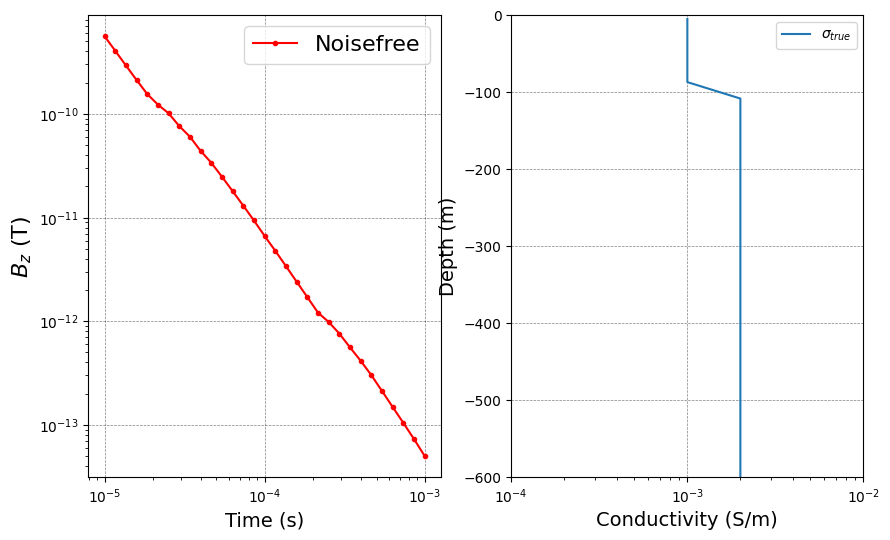

In [11]:
import pandas as pd
import numpy as np
from simpeg.electromagnetics import time_domain
from simpeg import (
    optimization,
    discretize,
    maps,
    data_misfit,
    regularization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
import matplotlib.pyplot as plt


def run(plotIt=True):
    cs, ncx, ncz, npad = 5.0, 25, 15, 15
    hx = [(cs, ncx), (cs, npad, 1.3)]
    hz = [(cs, npad, -1.3), (cs, ncz), (cs, npad, 1.3)]
    mesh = discretize.CylindricalMesh([hx, 1, hz], "00C")

    active = mesh.cell_centers_z < 0.0
    layer = (mesh.cell_centers_z < 0.0) & (mesh.cell_centers_z >= -100.0)
    actMap = maps.InjectActiveCells(mesh, active, np.log(1e-8), nC=mesh.shape_cells[2])
    mapping = maps.ExpMap(mesh) * maps.SurjectVertical1D(mesh) * actMap
    sig_half = 2e-3
    sig_air = 1e-8
    sig_layer = 1e-3
    sigma = np.ones(mesh.shape_cells[2]) * sig_air
    sigma[active] = sig_half
    sigma[layer] = sig_layer
    mtrue = np.log(sigma[active])

    rxOffset = 1e-3
    rx = time_domain.Rx.PointMagneticFluxTimeDerivative(
        np.array([[rxOffset, 0.0, 30]]), np.logspace(-5, -3, 31), "z"
    )
    src = time_domain.Src.MagDipole([rx], location=np.array([0.0, 0.0, 80]))
    survey = time_domain.Survey([src])
    time_steps = [(1e-06, 20), (1e-05, 20), (0.0001, 20)]
    simulation = time_domain.Simulation3DElectricField(
        mesh, sigmaMap=mapping, survey=survey, time_steps=time_steps
    )
    # d_true = simulation.dpred(mtrue)

    rel_err = 0.05
    data = simulation.make_synthetic_data(mtrue, relative_error=rel_err)
    # data
    
    # print(f" Data : {data.dobs}")
    if plotIt:
        fig, ax = plt.subplots(1, 2, figsize=(10, 6))
        #ax[0].loglog(rx.times, -invProb.dpred, "b.-")
        ax[0].loglog(rx.times, -data.dobs, "r.-")
        ax[0].legend(("Noisefree", "$d^{obs}$"), fontsize=16)
        ax[0].set_xlabel("Time (s)", fontsize=14)
        ax[0].set_ylabel("$B_z$ (T)", fontsize=16)
        ax[0].grid(color="k", alpha=0.5, linestyle="dashed", linewidth=0.5)

        plt.semilogx(sigma[active], mesh.cell_centers_z[active])
       # plt.semilogx(np.exp(mopt), mesh.cell_centers_z[active])
        # print(f"Semilogx: {np.exp(mopt)} | {sigma[active]} \n")
        ax[1].set_ylim(-600, 0)
        ax[1].set_xlim(1e-4, 1e-2)
        ax[1].set_xlabel("Conductivity (S/m)", fontsize=14)
        ax[1].set_ylabel("Depth (m)", fontsize=14)
        ax[1].grid(color="k", alpha=0.5, linestyle="dashed", linewidth=0.5)
        plt.legend([r"$\sigma_{true}$", r"$\sigma_{pred}$"])

    depths = mesh.cell_centers_z[active]
    resistivity = 1 / sigma[active]
    times = rx.times
    dBdt = data.dobs.flatten() 
    data_rows = []

    df = pd.DataFrame(data_rows, columns=["Time", "Depth", "Resistivity", "dBdt"])
    df.to_csv("synthetic_em_data.csv", index=False)

if __name__ == "__main__":
    run()
    plt.show()